**Goal of analysis: Which fights stats of a fighter are correlated with wins?**

Physical stats considered: Knockdowns, takedowns landed, significant strikes, submission attempts. 
Got data from 2020 onwards because I am more familiar with the modern trends of the sport (Data ends at 30 AUG). 

In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [339]:
event_df = pd.read_csv("ufc_data/ufc_event_data.csv")
fighter_df = pd.read_csv("ufc_data/ufc_fighters.csv")

In [340]:
event_df.dtypes

Event Name      object
Event Date      object
Result          object
Fighter1        object
Fighter2        object
KD              object
Strikes         object
TD              object
Sub             object
Weight Class    object
Method          object
Round            int64
Time            object
dtype: object

In [341]:
fighter_df.dtypes

First Name    object
Last Name     object
Nickname      object
Height        object
Weight        object
Reach         object
Stance        object
Wins           int64
Losses         int64
Draws          int64
dtype: object

In [342]:
fighter_df = fighter_df.drop(["Nickname"], axis=1) # Look up what axis means

fighter_df["Fighter Name"] = fighter_df["First Name"] + " " + fighter_df["Last Name"]
fighter_df = fighter_df.drop(["First Name", "Last Name"], axis=1)

fighter_df.head(5)

,Height,Weight,Reach,Stance,Wins,Losses,Draws,Fighter Name
0,--,155 lbs.,--,NaN,5,3,0,Tom Aaron
1,"5' 11""",155 lbs.,--,Orthodox,4,6,0,Danny Abbadi
2,"5' 8""",155 lbs.,"66.0""",Orthodox,28,4,0,Nariman Abbasov
3,"6' 2""",265 lbs.,"80.0""",Orthodox,9,5,0,Darion Abbey
4,"6' 0""",265 lbs.,--,Switch,10,15,0,David Abbott


In [343]:
event_df["Event Date"] = pd.to_datetime(event_df["Event Date"])

In [344]:
event_df = event_df.rename(columns={
    "Event Name": "Name",
    "Event Date": "Date",
    "KD": "Knockdowns",
    "TD": "Takedowns Landed", # Not attempted takedowns
    "Sub": "Submission Attempts",
    "Strikes": "Sig Strikes" # Not total strikes
})

In [345]:
event_df.head()

,Name,Date,Result,Fighter1,Fighter2,Knockdowns,Sig Strikes,Takedowns Landed,Submission Attempts,Weight Class,Method,Round,Time
0,UFC Fight Night: Walker vs. Zhang,2025-08-23,Johnny Walker,Johnny Walker,Zhang Mingyang,1-0,50-20,0-0,0-0,Light Heavyweight,KO/TKO-Punches,2,2:37
1,UFC Fight Night: Walker vs. Zhang,2025-08-23,Aljamain Sterling,Aljamain Sterling,Brian Ortega,0-0,124-55,3-0,0-0,Catch Weight,U-DEC,5,5:00
2,UFC Fight Night: Walker vs. Zhang,2025-08-23,Sergei Pavlovich,Sergei Pavlovich,Waldo Cortes-Acosta,0-0,61-45,0-0,0-0,Heavyweight,U-DEC,3,5:00
3,UFC Fight Night: Walker vs. Zhang,2025-08-23,Sumudaerji,Sumudaerji,Kevin Borjas,0-0,73-16,0-0,0-0,Flyweight,U-DEC,3,5:00
4,UFC Fight Night: Walker vs. Zhang,2025-08-23,Taiyilake Nueraji,Taiyilake Nueraji,Kiefer Crosbie,0-0,27-2,1-0,0-0,Welterweight,KO/TKO-Elbows,1,3:33


In [ ]:
# separate the fighter1 and fighter2 stuff from the dash. E.g. Fighter1_TD, Fighter2_KD, etc...
from separate_endash import separate_endash # Probably better to have just used re.split(), but I only realised after writing the function

for col in ("Sig Strikes", "Takedowns Landed", "Submission Attempts", "Knockdowns"):
    event_df[f"Fighter1 {col}"] = event_df[col].apply(lambda x: separate_endash(x)[0])
    event_df[f"Fighter2 {col}"] = event_df[col].apply(lambda x: separate_endash(x)[1])

event_df = event_df.drop(columns=["Sig Strikes", "Takedowns Landed", "Submission Attempts", "Knockdowns"])

event_df.dtypes

Name                                    object
Date                            datetime64[ns]
Result                                  object
Fighter1                                object
Fighter2                                object
Weight Class                            object
Method                                  object
Round                                    int64
Time                                    object
Fighter1 Sig Strikes                     int64
Fighter2 Sig Strikes                     int64
Fighter1 Takedowns Landed                int64
Fighter2 Takedowns Landed                int64
Fighter1 Submission Attempts             int64
Fighter2 Submission Attempts             int64
Fighter1 Knockdowns                      int64
Fighter2 Knockdowns                      int64
dtype: object

In [347]:
event_df = event_df.drop(columns=["Weight Class", "Round", "Time", "Name", "Date"])

In [348]:
# Fighter1 is the winner (unless it's a draw or NC)
# I'm going to ignore draws and NCs

event_df = event_df[~event_df["Result"].isin(["Draw", "NC"])]

In [349]:
"""
Change "Fighter1" to "Winner" and "Fighter2" to "Loser" since i've sorted out the draws and NCs.
"""

"""
dict methods: 
    .keys() → keys only
    .values() → values only
    .items() → both, as pairs
"""

base_dict = {
    "Fighter1": "Winner",
    "Fighter2": "Loser"
}

stats = ["", "Sig Strikes", "Takedowns Landed", "Submission Attempts", "Knockdowns"]

renaming = {}
for fighter, w_or_l in base_dict.items():
    for stat in stats:
        renaming[f"{fighter} {stat}"] = f"{w_or_l} {stat}"

event_df = event_df.rename(columns=renaming)


In [350]:
event_df.head()

,Result,Fighter1,Fighter2,Method,Winner Sig Strikes,Loser Sig Strikes,Winner Takedowns Landed,Loser Takedowns Landed,Winner Submission Attempts,Loser Submission Attempts,Winner Knockdowns,Loser Knockdowns
0,Johnny Walker,Johnny Walker,Zhang Mingyang,KO/TKO-Punches,50,20,0,0,0,0,1,0
1,Aljamain Sterling,Aljamain Sterling,Brian Ortega,U-DEC,124,55,3,0,0,0,0,0
2,Sergei Pavlovich,Sergei Pavlovich,Waldo Cortes-Acosta,U-DEC,61,45,0,0,0,0,0,0
3,Sumudaerji,Sumudaerji,Kevin Borjas,U-DEC,73,16,0,0,0,0,0,0
4,Taiyilake Nueraji,Taiyilake Nueraji,Kiefer Crosbie,KO/TKO-Elbows,27,2,1,0,0,0,0,0


In [351]:
fight_results_df = event_df
fight_results_df.dtypes

Result                        object
Fighter1                      object
Fighter2                      object
Method                        object
Winner Sig Strikes             int64
Loser Sig Strikes              int64
Winner Takedowns Landed        int64
Loser Takedowns Landed         int64
Winner Submission Attempts     int64
Loser Submission Attempts      int64
Winner Knockdowns              int64
Loser Knockdowns               int64
dtype: object

In [352]:
"""
Q: Which fights stats of a fighter are correlated with wins?
A: All 4 of the fight stats listed below - the higher the numbers are the more correlation with the corresponsding fighter winning. 
"""
fight_results_df.describe()

# MAKE A COMPARISON CHART - LOOKS LIKE A BAR CHART BUT WITH BIG GAPS

,Winner Sig Strikes,Loser Sig Strikes,Winner Takedowns Landed,Loser Takedowns Landed,Winner Submission Attempts,Loser Submission Attempts,Winner Knockdowns,Loser Knockdowns
count,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000
mean,53.515831,37.349698,1.423693,0.658129,0.429385,0.154038,0.367485,0.052295
std,39.676880,31.876883,2.024791,1.199119,0.816366,0.501351,0.608770,0.236608
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76.000000,55.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,445.000000,271.000000,14.000000,9.000000,7.000000,5.000000,6.000000,2.000000


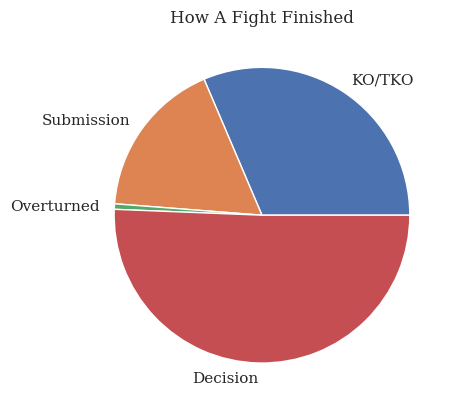

In [353]:
"""
How did the fights end?
"""

fight_ended_df = pd.read_csv("ufc_data/ufc_event_data.csv")["Method"]

# fight_ended_df.unique()
# ko_tko_replacement_list = [value for value in fight_ended_df.unique() if ("KO/TKO" in value)]
# submission_replace_list = [value for value in fight_ended_df.unique() if ("SUB" in value)]
# overturned_replace_list = [value for value in fight_ended_df.unique() if ("Overturned" in value)]
# decision_replace_list = [value for value in fight_ended_df.unique() if ("DEC" in value)]
# fight_ended_df = fight_ended_df.replace(ko_tko_replacement_list, "KO/TKO")
# fight_ended_df = fight_ended_df.replace(submission_replace_list, "SUB")
# fight_ended_df = fight_ended_df.replace(overturned_replace_list, "Overturned")
# fight_ended_df = fight_ended_df.replace(decision_replace_list, "DEC")

# ts was generated by AI.
replacement_map = {
    r".*KO/TKO.*": "KO/TKO",
    r".*SUB.*": "Submission",
    r".*Overturned.*": "Overturned",
    r".*DEC.*": "Decision"
}

fight_ended_df = fight_ended_df.replace(replacement_map, regex=True) # also ai generated

fight_ended_count = [(fight_ended_df == method).sum() for method in ("KO/TKO","Submission", "Overturned", "Decision")]
methods = [value for value in replacement_map.values()]

sns.set_theme(style="whitegrid", font="Serif")
colors = sns.color_palette('pastel')[0:len(fight_ended_count)]

plt.title("How A Fight Finished")
plt.pie(fight_ended_count, labels=methods)
plt.show()


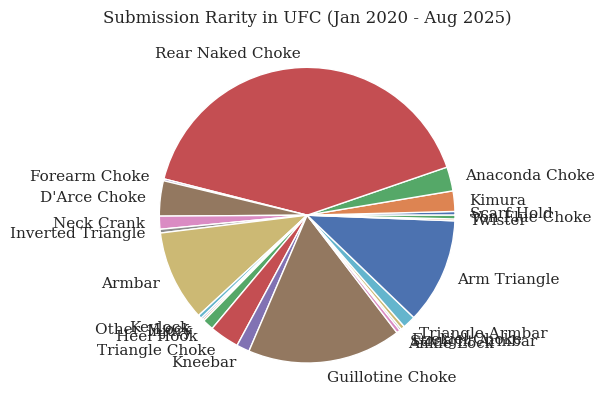

In [354]:
"""
Looking at the Submission subset. ts interesting 
"""

fight_ended_df = pd.read_csv("ufc_data/ufc_event_data.csv")["Method"] # this is as series not df, so syntax is slightly different

def is_submission(series):
    subs_list = []
    for term in series:
        if "SUB" in term:
            subs_list.append(term)
        else: 
            continue
    return subs_list

subs = pd.Series(is_submission(fight_ended_df))
subs_set = set(subs)
subs_num_list = [(fight_ended_df == method).sum() for method in subs_set]
new_subs_set = []
for element in subs_set:
    element = element[4:len(element)]
    element = element.replace("-", " ")
    new_subs_set.append(element)


plt.title("Submission Rarity in UFC (Jan 2020 - Aug 2025)") # is rarity the right word?
plt.pie(subs_num_list, labels=new_subs_set)
plt.show() # why is this so clumped bruh

In [355]:
for element in zip(new_subs_set, subs_num_list):
    print(element)

('Scarf Hold', np.int64(2))
('Kimura', np.int64(11))
('Anaconda Choke', np.int64(13))
('Rear Naked Choke', np.int64(201))
('Forearm Choke', np.int64(1))
("D'Arce Choke", np.int64(19))
('Neck Crank', np.int64(7))
('Inverted Triangle', np.int64(2))
('Armbar', np.int64(49))
('Keylock', np.int64(2))
('Other   Lock', np.int64(1))
('Injury', np.int64(1))
('Heel Hook', np.int64(6))
('Triangle Choke', np.int64(16))
('Kneebar', np.int64(7))
('Guillotine Choke', np.int64(83))
('Ankle Lock', np.int64(2))
('Straight Armbar', np.int64(1))
('Ezekiel Choke', np.int64(2))
('Triangle Armbar', np.int64(7))
('Arm Triangle', np.int64(57))
('Twister', np.int64(1))
('Von Flue Choke', np.int64(2))
